In [1]:
from base import *
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

from skfuzzy import cluster
from itertools import combinations
from xgboost import XGBClassifier

import scipy
from scipy.spatial import distance

In [2]:
STOPWORDS = set(stopwords.words('english'))
PUNCT_TRANS = str.maketrans('', '', string.punctuation)

# Functions
## Dataset

In [3]:
def read_data(path='./liar_dataset'):
    features = ['ID', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'affiliation',
         'barely-true', 'false', 'half-true', 'mostly-true', 'pant-on-fire', 'context']
    
    # merge train.tsv + valid.tsv
    TRAIN = pd.concat([pd.read_csv(path+'/train.tsv', delimiter='\t', names=features, quoting=3),
                        pd.read_csv(path+'/valid.tsv', delimiter='\t', names=features, quoting=3)],
                        ignore_index=True)

    TEST = pd.read_csv(path+'/test.tsv', delimiter='\t', names=features, quoting=3)
    
    return TRAIN, TEST

## Preprocessing

In [4]:
def subtract_current_credit(row):
    """
    
    Subtract the current label from the credit history of current statement.
        
    """
    label = row['label'] 
    try:
        row[label] -= 1  
    except:
        pass
    return row
    
def fill_na(data):
    """

    Preproces steps of LIAR dataset which is include:
        * Define which are text features
        * Define which are numeric features (credit history)
        * Fill the blanks (missing cell) of text features with word [unknow]
        * Prevent data leakage from numeric features
            According to dataset author: 
                "Credit history include the count of the current statement, 
                it is important to subtract the current label from the credit history when using this 
                meta data vector in prediction experiments."

    """
    text_features = ['statement', 'subject', 'speaker', 'job', 'state', 'affiliation', 'context']
    num_features = ['barely-true', 'false', 'half-true', 'mostly-true', 'pant-on-fire']
    data[text_features] = data[text_features].fillna("unknown").astype(str)
    data[num_features] = data[num_features].fillna(0).astype(int)
    
    # subtract current_credit
    data = data.apply(subtract_current_credit, axis=1)
    return data

In [5]:
def TXT_preprocess(text):
    """
    
    Clean statement feature.
    
    """
    text = text.lower()
    text = text.translate(PUNCT_TRANS)
    text = ' '.join([word for word in word_tokenize(text) if word not in STOPWORDS])
    return text

def context_preprocess(text):
    """
    
    Clean context feature.
    
    """
    text = text.lower()
    text = re.sub('e mail|e-mail|email|mailer','mail', text)
    text = re.sub('television','tv', text)
    text = re.sub('website','web', text)
    text = text.translate(PUNCT_TRANS)
    text = ' '.join([word for word in word_tokenize(text) if word not in STOPWORDS])
    return text
    
def subject_preprocess(text):
    """
    
    Clean subject feature.
    
    """
    text = text.lower()
    text = ' '.join(text.split(','))
    return text

def job_preprocess(text):
    """
    
    Clean job feature.
    
    """
    text = text.lower()
    text = text.translate(PUNCT_TRANS)
    return text
def calculate_centroids(X, y):
    # print(X.shape, y.shape)
    n_class = np.unique(y)
    centroids = np.empty(( n_class.shape[0], X.shape[1]))
    for i in n_class:
        centroids[i, :] = X[y==i].mean(axis=0)
    return centroids

In [6]:
class TXT_Transformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X['statement'].apply(TXT_preprocess)

class TXT_Fuzzifier(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.centroids = []
        self.map = {
            'pants-fire'  : 0, 
            'false'       : 1, 
            'barely-true' : 2, 
            'half-true'   : 3, 
            'mostly-true' : 4, 
            'true'        : 5
        }

    def fit(self, X, y=None):
        temp_map = {}
        self.centroids.append(calculate_centroids(X, np.vectorize(self.map.get)(y)))
        for i in [1, 2]:
            for com in combinations(range(6), i):
                for key in self.map.keys():
                    temp_map[key] = 0 if self.map[key] in com else 1
                y_ = np.vectorize(temp_map.get)(y)
                self.centroids.append(calculate_centroids(X, y_))
            
        return self
    def transform(self, X):
        U = np.empty((X.shape[0], 5+len(self.centroids)))
        d = np.empty((X.shape[0], 6))
        for i in range(X.shape[0]):
            d[i, :] = distance.cdist(X.getrow(i).todense(), self.centroids[0])
        
        U[:, :6] = cluster.normalize_columns.normalize_power_columns(d, -2./(2 - 1))
        
        d = np.empty((X.shape[0], 2))
        for indx, cntr in enumerate(self.centroids[1:]):
            for i in range(X.shape[0]):
                d[i, :] = distance.cdist(X.getrow(i).todense(), cntr)
            U[:, indx+6] = cluster.normalize_columns.normalize_power_columns(d, -2./(2 - 1))[:, 0]
        return U


class CT_Transformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        output = pd.DataFrame()
        output['context'] = X['context'].apply(context_preprocess)
        output['subject'] = X['subject'].apply(subject_preprocess)
        output['job'] = X['job'].apply(job_preprocess)
        output['state'] = X['state'].str.lower()
        output['affiliation'] = X['affiliation'].str.lower()
        return output
        
class CT_Vectorizer(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.context_vtr = TfidfVectorizer()
        self.subject_vtr = CountVectorizer(binary=True)
        self.job_vtr = CountVectorizer(binary=True)
        self.state_vtr = CountVectorizer(binary=True)
        self.affiliation_vtr = CountVectorizer(binary=True)
        
    def fit(self, X, y=None):
        self.context_vtr.fit(X['context'])
        self.subject_vtr.fit(X['subject'])
        self.job_vtr.fit(X['job'])
        self.state_vtr.fit(X['state'])
        self.affiliation_vtr.fit(X['affiliation'])
        return self
    def transform(self, X):
        return scipy.sparse.hstack((
            self.context_vtr.transform(X['context']),
            self.subject_vtr.transform(X['subject']),
            self.job_vtr.transform(X['job']),
            self.state_vtr.transform(X['state']),
            self.affiliation_vtr.transform(X['affiliation'])
        ))
        
class CH_Transformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[['barely-true', 'false', 'half-true', 'mostly-true', 'pant-on-fire']].values


## Parameters + Map

In [7]:
bin_param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [.1, .2, .3, .4, .5],
        'max_depth': [2, 3, 4]
    }
multi_param_grid = {
    'objective' : ['multi:softmax'],
    'n_estimators': [50, 100, 150],
    'learning_rate': [.01, .1, .5],
    'max_depth': [3, 6, 9]
}

## Modeling

In [8]:
class Binary_models(TransformerMixin, BaseEstimator):
    def __init__(self, *, param_grid=None):
        self.models = []
        self.param_grid = param_grid
        self.maps = [
                {
                    'pants-fire'  : 0, 
                    'false'       : 0, 
                    'barely-true' : 1, 
                    'half-true'   : 1, 
                    'mostly-true' : 1, 
                    'true'        : 1
                },
                {
                    'pants-fire'  : 0, 
                    'false'       : 0, 
                    'barely-true' : 1, 
                    'half-true'   : 1, 
                    'mostly-true' : 0, 
                    'true'        : 0
                },
                {
                    'pants-fire'  : 0, 
                    'false'       : 0, 
                    'barely-true' : 0, 
                    'half-true'   : 0, 
                    'mostly-true' : 1, 
                    'true'        : 1
                },
                {
                    'pants-fire'  : 0, 
                    'false'       : 0, 
                    'barely-true' : 0, 
                    'half-true'   : 1, 
                    'mostly-true' : 1, 
                    'true'        : 1
                }
            ]
    def fit(self, X, y=None):
        for i in range(4):
            y_ = np.vectorize(self.maps[i].get)(y)
            search = GridSearchCV(
                estimator=XGBClassifier(),
                param_grid=self.param_grid,
                scoring= 'neg_log_loss',
                cv=3
            )
            search.fit(X, y_)
            self.models.append(search)
        return self

    def transform(self, X):
        pred = np.empty((X.shape[0], 4))
        for i in range(4):
            pred[:, i] = self.models[i].predict_proba(X)[:, 0]
        return pred

class MultiClass_model(ClassifierMixin, BaseEstimator):
    
    def __init__(self, *, param_grid=None):
        self.model = None
        self.param_grid = param_grid
        self.map = {
            'pants-fire'  : 0, 
            'false'       : 1, 
            'barely-true' : 2, 
            'half-true'   : 3, 
            'mostly-true' : 4, 
            'true'        : 5
        }
        self.truth_class = {
            0 : 'pants-fire', 
            1 : 'false'     ,
            2 : 'barely-true',
            3 : 'half-true'  ,
            4 : 'mostly-true',
            5 : 'true'
        }
    def fit(self, X, y=None):
        y_ = np.vectorize(self.map.get)(y)
        search = GridSearchCV(
            estimator=XGBClassifier(),
            param_grid=self.param_grid,
            scoring= 'neg_log_loss',
            cv=5
        )
        self.model = search.fit(X, y_)
        return self
        
    def predict(self, X):
        pred = self.model.predict(X)
        return np.vectorize(self.truth_class.get)(pred)


In [9]:
TXT_pipeline = Pipeline([
        ('TXT_clean', TXT_Transformer()),
        ('TXT_vector', TfidfVectorizer()),
        ('TXT_Fz', TXT_Fuzzifier()),
        # ('TXT_chi2', SelectKBest(score_func=chi2, k=1000)),
        # ('TXT_extract', FeatureUnion(
        #     [('TXT_chi2', SelectKBest(score_func=chi2, k=700)),
        #     ('TXT_Fz', TXT_Fuzzifier())]
        #     , n_jobs=-1
        # )),
        # ('TXT_scaler', MaxAbsScaler()),
        ('TXT_binary', Binary_models(param_grid=bin_param_grid))
    ])
CT_pipeline = Pipeline([
        ('CT_clean', CT_Transformer()),
        ('CT_vector', CT_Vectorizer()),
        ('CT_binary', Binary_models(param_grid=bin_param_grid))
    ])
CH_pipeline = Pipeline([('CH_clean', CH_Transformer())])

FzXGBoost_pipeline = Pipeline(
    [
        ('Union', FeatureUnion(
            [
                ('TXT', TXT_pipeline),
                ('CT', CT_pipeline),
                ('CH', CH_pipeline)
            ]
            ,n_jobs=-1
        )),
        ('Scaler', MinMaxScaler()),
        ('Classifier', MultiClass_model(param_grid=multi_param_grid))
    ],
    verbose=True)

In [10]:
TRAIN, TEST = read_data()

y_train = TRAIN['label'].values
y_test = TEST['label'].values

X_train = fill_na(TRAIN).drop(columns=['ID', 'label', 'speaker'])
X_test = fill_na(TEST).drop(columns=['ID', 'label', 'speaker'])

In [ ]:
FzXGBoost_pipeline.fit(X_train, y_train)

pred_train = FzXGBoost_pipeline.predict(X_train)
pred_test = FzXGBoost_pipeline.predict(X_test)

In [13]:
print('TRAINING accuracy: ',accuracy_score(y_train, pred_train))
print('TEST accuracy: ',accuracy_score(y_test, pred_test))

TRAINING accuracy:  0.7605816670994547
TEST accuracy:  0.45908028059236167


In [14]:
print('REPORT: training set\n',classification_report(y_train, pred_train))

REPORT: training set
               precision    recall  f1-score   support

 barely-true       0.77      0.79      0.78      1894
       false       0.74      0.76      0.75      2261
   half-true       0.76      0.83      0.80      2371
 mostly-true       0.72      0.71      0.72      2217
  pants-fire       0.83      0.84      0.84       958
        true       0.78      0.65      0.71      1852

    accuracy                           0.76     11553
   macro avg       0.77      0.77      0.77     11553
weighted avg       0.76      0.76      0.76     11553



In [15]:
print('REPORT: test set\n',classification_report(y_test, pred_test))

REPORT: test set
               precision    recall  f1-score   support

 barely-true       0.39      0.42      0.40       214
       false       0.37      0.72      0.49       250
   half-true       0.76      0.36      0.49       267
 mostly-true       0.48      0.53      0.50       249
  pants-fire       0.49      0.74      0.59        92
        true       0.82      0.11      0.19       211

    accuracy                           0.46      1283
   macro avg       0.55      0.48      0.44      1283
weighted avg       0.56      0.46      0.44      1283



<Figure size 1000x700 with 0 Axes>

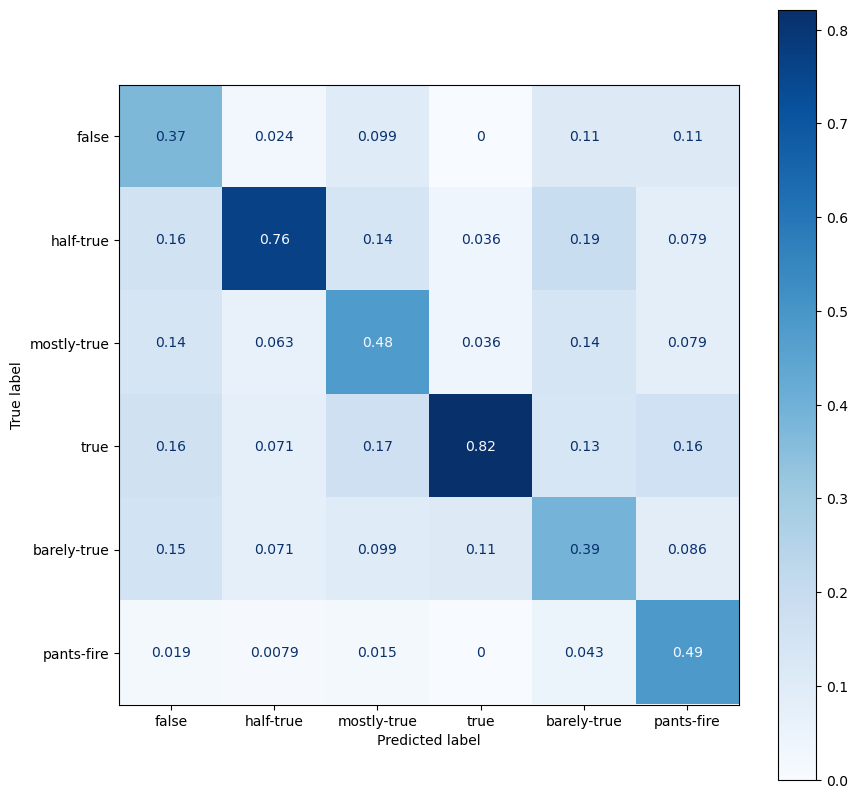

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

cm = confusion_matrix(y_test, pred_test, labels= TRAIN['label'].unique(), normalize='pred')
cmp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=TRAIN['label'].unique())
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(cmap = 'Blues', ax=ax);

In [17]:
import joblib
joblib.dump(FzXGBoost_pipeline, 'MultiLayer_Fz.pkl')

['MultiLayer_Fz.pkl']